In [ ]:
!unzip -q /content/drive/MyDrive/cassava.zip


In [ ]:
import pandas as pd
data=pd.read_csv('/content/train.csv')
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.20, random_state=42)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

val, test = train_test_split(test, test_size=0.50, random_state=42)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
print(train.shape)
print(val.shape)
print(test.shape)

(17117, 2)
(2140, 2)
(2140, 2)


In [ ]:
import glob
import shutil
import os

!rm -rf train
!rm -rf val
!rm -rf test

!mkdir train
!mkdir val
!mkdir test

folders=list(data.label.unique())
folders
for i in folders:
  !mkdir /content/train/{i}
  !mkdir /content/val/{i}
  !mkdir /content/test/{i}

for i in range(train.shape[0]):
  shutil.copy('/content/train_images/'+ str(train['image_id'][i]), '/content/train/'+ str(train['label'][i]))

for i in range(val.shape[0]):
  shutil.copy('/content/train_images/'+ str(val['image_id'][i]), '/content/val/'+ str(val['label'][i]))

for i in range(test.shape[0]):
  shutil.copy('/content/train_images/'+ str(test['image_id'][i]), '/content/test/'+ str(test['label'][i]))


In [ ]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.applications.resnet152V2 import ResNet152V2
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# derive the paths to the training, validation, and testing
# directories
trainPath = 'train'
valPath = 'val'
testPath = 'test'
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	trainPath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=32)
# initialize the validation generator
valGen = valAug.flow_from_directory(
	valPath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32)
# initialize the testing generator
testGen = valAug.flow_from_directory(
	testPath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=32)

Found 17117 images belonging to 5 classes.
Found 2140 images belonging to 5 classes.
Found 2140 images belonging to 5 classes.


In [ ]:
CLASSES=['0','1','2','3','4']

In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // 32,
	validation_data=valGen,
	validation_steps=totalVal // 32,
	epochs=20)
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict(x=testGen,
	steps=(totalTest // 32) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
# plot_training(H, 50, config.WARMUP_PLOT_PATH)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
534/534 [==============================] - 386s 722ms/step - loss: 2.2473 - accuracy: 0.5735 - val_loss: 1.0483 - val_accuracy: 0.6454
Epoch 2/20
534/534 [==============================] - 383s 718ms/step - loss: 1.0748 - accuracy: 0.6227 - val_loss: 0.9963 - val_accuracy: 0.6491
Epoch 3/20
534/534 [==============================] - 382s 715ms/step - loss: 1.0219 - accuracy: 0.6331 - val_loss: 0.9564 - val_accuracy: 0.6534
Epoch 4/20
534/534 [==============================] - 380s 712ms/step - loss: 0.9996 - accuracy: 0.6369 - val_loss: 0.9295 - val_accuracy: 0.6610
Epoch 5/20
534/534 [==============================] - 381s 714ms/step - loss: 0.9797 - accuracy: 0.6370 - val_loss: 0.9204 - val_accuracy: 0.6553
Epoch 6/20
534/534 [==============================] - 380s 712ms/step - loss: 0.9628 - accuracy: 0.6448 - val_loss: 0.9077 - val_accuracy: 0.6586
Epoch 7/20
534/534 [==============================] - 382s 715ms/step - lo

In [ ]:
# reset our data generators
trainGen.reset()
valGen.reset()
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
	layer.trainable = True
# loop over the layers in the model and show which ones are trainable
# or not
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdd84435898>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd8438c6d8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd8438ca20>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdd8438c8d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd84356ac8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd843725f8>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdd843729e8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd8437a588>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd84381400>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd84381828>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdd84387400>: False
<tensorflow.python.keras.layers.convolutional.Conv2D

In [ ]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // 32,
	validation_data=valGen,
	validation_steps=totalVal // 32,
	epochs=10)

[INFO] re-compiling model...
Epoch 1/10
534/534 [==============================] - 404s 757ms/step - loss: 0.8659 - accuracy: 0.6745 - val_loss: 0.7845 - val_accuracy: 0.6946
Epoch 2/10
534/534 [==============================] - 403s 755ms/step - loss: 0.8161 - accuracy: 0.6908 - val_loss: 0.7131 - val_accuracy: 0.7178
Epoch 3/10
534/534 [==============================] - 402s 752ms/step - loss: 0.7769 - accuracy: 0.7076 - val_loss: 0.7026 - val_accuracy: 0.7386
Epoch 4/10
534/534 [==============================] - 397s 743ms/step - loss: 0.7556 - accuracy: 0.7168 - val_loss: 0.7206 - val_accuracy: 0.7230
Epoch 5/10
534/534 [==============================] - 397s 743ms/step - loss: 0.7347 - accuracy: 0.7250 - val_loss: 0.7298 - val_accuracy: 0.7169
Epoch 6/10
534/534 [==============================] - 395s 740ms/step - loss: 0.7173 - accuracy: 0.7337 - val_loss: 0.6724 - val_accuracy: 0.7467
Epoch 7/10
534/534 [==============================] - 399s 747ms/step - loss: 0.6970 - accuracy

In [ ]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict(x=testGen,
	steps=(totalTest // 32) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
# plot_training(H, 20, config.UNFROZEN_PLOT_PATH)
# serialize the model to disk
# print("[INFO] serializing network...")
# model.save(config.MODEL_PATH, save_format="h5")

[INFO] evaluating after fine-tuning network...
              precision    recall  f1-score   support

           0       0.48      0.33      0.39        97
           1       0.63      0.55      0.59       207
           2       0.78      0.35      0.48       231
           3       0.88      0.94      0.91      1364
           4       0.48      0.68      0.57       241

    accuracy                           0.78      2140
   macro avg       0.65      0.57      0.59      2140
weighted avg       0.79      0.78      0.77      2140



In [ ]:
# reset our data generators
trainGen.reset()
valGen.reset()
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[11:]:
	layer.trainable = True
# loop over the layers in the model and show which ones are trainable
# or not
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fdd84435898>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd8438c6d8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd8438ca20>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdd8438c8d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd84356ac8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd843725f8>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdd843729e8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd8437a588>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd84381400>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fdd84381828>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fdd84387400>: False
<tensorflow.python.keras.layers.convolutional.Conv2D

In [ ]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // 32,
	validation_data=valGen,
	validation_steps=totalVal // 32,
	epochs=10)

[INFO] re-compiling model...
Epoch 1/10
534/534 [==============================] - 421s 789ms/step - loss: 0.6793 - accuracy: 0.7514 - val_loss: 0.6535 - val_accuracy: 0.7656
Epoch 2/10
534/534 [==============================] - 421s 789ms/step - loss: 0.6513 - accuracy: 0.7670 - val_loss: 0.6449 - val_accuracy: 0.7604
Epoch 3/10
534/534 [==============================] - 421s 788ms/step - loss: 0.6179 - accuracy: 0.7749 - val_loss: 0.5986 - val_accuracy: 0.7865
Epoch 4/10
534/534 [==============================] - 421s 788ms/step - loss: 0.6045 - accuracy: 0.7821 - val_loss: 0.6114 - val_accuracy: 0.7756
Epoch 5/10
534/534 [==============================] - 420s 787ms/step - loss: 0.5817 - accuracy: 0.7893 - val_loss: 0.6039 - val_accuracy: 0.7789
Epoch 6/10
534/534 [==============================] - 421s 789ms/step - loss: 0.5686 - accuracy: 0.7954 - val_loss: 0.6045 - val_accuracy: 0.7841
Epoch 7/10
534/534 [==============================] - 418s 783ms/step - loss: 0.5591 - accuracy

In [ ]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict(x=testGen,
	steps=(totalTest // 32) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
# plot_training(H, 20, config.UNFROZEN_PLOT_PATH)
# serialize the model to disk
# print("[INFO] serializing network...")
model.save('cassava.model', save_format="h5")

[INFO] evaluating after fine-tuning network...
              precision    recall  f1-score   support

           0       0.65      0.31      0.42        97
           1       0.73      0.63      0.68       207
           2       0.71      0.53      0.60       231
           3       0.92      0.92      0.92      1364
           4       0.49      0.76      0.60       241

    accuracy                           0.81      2140
   macro avg       0.70      0.63      0.64      2140
weighted avg       0.82      0.81      0.81      2140



In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# load the input image and then clone it so we can draw on it later
image = cv2.imread('/content/2216849948.jpg')
output = image.copy()
output = imutils.resize(output, width=400)
# our model was trained on RGB ordered images but OpenCV represents
# images in BGR order, so swap the channels, and then resize to
# 224x224 (the input dimensions for VGG16)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
# convert the image to a floating point data type and perform mean
# subtraction
image = image.astype("float32")
mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
image -= mean

[INFO] loading model...


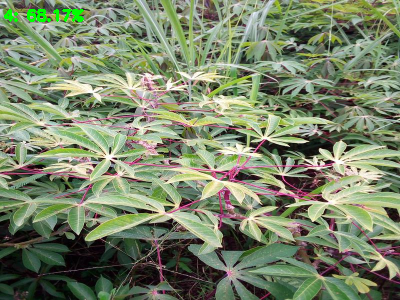

-1

In [ ]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('cassava.model')
# pass the image through the network to obtain our predictions
preds = model.predict(np.expand_dims(image, axis=0))[0]
i = np.argmax(preds)
label = CLASSES[i]
# draw the prediction on the output image
text = "{}: {:.2f}%".format(label, preds[i] * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
	(0, 255, 0), 2)
# show the output image
cv2_imshow(output)
cv2.waitKey(0)

In [ ]:
!zip -r '/content/cassava.model.zip' '/content/cassava.model'

  adding: content/cassava.model (deflated 13%)
